# Setup

In [1]:
!pip uninstall --yes gdown 
!pip install gdown -U --no-cache-dir
!pip install --upgrade astropy
!pip install --upgrade photutils
!pip3 install -U segmentation-models
!pip install patchify

Found existing installation: gdown 4.5.1
Uninstalling gdown-4.5.1:
  Successfully uninstalled gdown-4.5.1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=3d33d3689f4c8904bb0cdd273e712b567bc2ade461ea728bf8c3b8ff4ccee203
  Stored in directory: C:\Users\Giulio\AppData\Local\Temp\pip-ephem-wheel-cache-oasexk5s\wheels\b8\79\f0\b523d25d96b0bbb12bb024b97940d08c4fcd498a00070c8d82
Successfully built gdown


In [2]:
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
from photutils.segmentation import detect_sources
from astropy.visualization import ZScaleInterval
import requests
import shutil
import time
import random
import json
import os
from PIL import Image
from tqdm import tqdm
import pickle

# Load the dataset

In [3]:
def load_dataset(image_ds_path, mask_ds_path):
    with open(image_ds_path, 'rb') as handle:
        image_dataset = pickle.load(handle)
    image_dataset = image_dataset.reshape(-1, 256, 256)

    with open(mask_ds_path, 'rb') as handle:
        mask_dataset = pickle.load(handle)
    mask_dataset = mask_dataset.reshape(-1, 256, 256)

    return image_dataset, mask_dataset

In [4]:
#image_dataset1, mask_dataset1 = load_dataset('image_dataset1.pickle', 'mask_dataset1.pickle')
#image_dataset2, mask_dataset2 = load_dataset('image_dataset2.pickle', 'mask_dataset2.pickle')
image_dataset3, mask_dataset3 = load_dataset('image_dataset3.pickle', 'mask_dataset3.pickle')
image_dataset4, mask_dataset4 = load_dataset('image_dataset4.pickle', 'mask_dataset4.pickle')

# The cleaning

In [10]:
def cleaning(img):
    bkg_estimator = MedianBackground()
    bkg = Background2D(img, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator,
                       exclude_percentile=15.0)
    img_back = img - bkg.background  # subtract the background
    
    threshold = 1.5 * bkg.background_rms
    
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.
    convolved_img = convolve(img_back, kernel)
    
    segment_map = detect_sources(convolved_img, threshold, npixels=10)
    segment_map = np.array(segment_map)
    segment_map[segment_map > 0] = 1
    
    return segment_map

In [11]:
def Cleaning_ds(dataset):
    final = []
    for IMG in tqdm(dataset):
        final.append(cleaning(IMG))
    return final

In [12]:
image_dataset3[0]

array([[0.00053123, 0.        , 0.00053123, ..., 0.        , 0.00106246,
        0.        ],
       [0.        , 0.        , 0.00053123, ..., 0.00053123, 0.00053123,
        0.        ],
       [0.00053123, 0.        , 0.00053123, ..., 0.        , 0.        ,
        0.00053123],
       ...,
       [0.01060028, 0.01377033, 0.02587862, ..., 0.        , 0.00053123,
        0.        ],
       [0.01112901, 0.02114872, 0.03269261, ..., 0.        , 0.        ,
        0.        ],
       [0.01165757, 0.0237777 , 0.03948526, ..., 0.        , 0.        ,
        0.        ]])

In [13]:
#predictions1 = Cleaning_ds(image_dataset1)
#predictions2 = Cleaning_ds(image_dataset2)
predictions3 = Cleaning_ds(image_dataset3)
predictions4 = Cleaning_ds(image_dataset4)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:59<00:00, 20.86it/s]


# Evaluation

In [14]:
from sklearn.metrics import confusion_matrix

def confusion_mat(pred, true):
    pred[pred > 0] = 1.
    pred = pred.flatten()
    true = true.flatten()
    tn, fp, fn, tp = confusion_matrix(pred, true).ravel()
    return tn, fp, fn, tp

def averageIoU(preds, true):
    ious = np.zeros(shape = len(preds), dtype = np.float32)
    for i in tqdm(range(len(preds))):
        tn, fp, fn, tp = confusion_mat(preds[i], true[i])
        ious[i] = tp / (tp + fp + fn)
    return np.mean(ious)

def averageRecall(preds, true):
    recalls = np.zeros(shape = len(preds), dtype = np.float32)
    for i in tqdm(range(len(preds))):
        tn, fp, fn, tp = confusion_mat(preds[i], true[i])
        recalls[i] = tp / (tp + fn)
    return np.mean(recalls)

def averageDice(preds, true):
    dices = np.zeros(shape = len(preds), dtype = np.float32)
    for i in tqdm(range(len(preds))):
        tn, fp, fn, tp = confusion_mat(preds[i], true[i])
        dices[i] = (2*tp) / ((2*tp) + fp + fn)
    return np.mean(dices)

def averageAccuracy(preds, true):
    accuracies = np.zeros(shape = len(preds), dtype = np.float32)
    for i in tqdm(range(len(preds))):
        tn, fp, fn, tp = confusion_mat(preds[i], true[i])
        accuracies[i] = (tp+tn) / (tn + fp + fn + tp)
    return np.mean(accuracies)

def Evaluation(preds, true):
    eval = {}
    eval['IoU'] = averageIoU(preds, true)
    eval['recall'] = averageRecall(preds, true)
    eval['dice_coeff'] = averageDice(preds, true)
    eval['Accuracy'] = averageAccuracy(preds, true)
    return eval

In [15]:
#eval1 = Evaluation(predictions1, mask_dataset1)
#eval2 = Evaluation(predictions2, mask_dataset2)
eval3 = Evaluation(predictions3, mask_dataset3)
eval4 = Evaluation(predictions4, mask_dataset4)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:27<00:00, 90.43it/s]


In [16]:
# create df
metrics_dict = {}
#metrics_dict['Image w/Normalize'] = eval1
#metrics_dict['Image software w/Normalize'] = eval2
metrics_dict['Image software + rms w/Normalize'] = eval3
metrics_dict['Image software+ rms w/Normalize and streatch'] = eval4

metrics_df = pd.DataFrame.from_dict(metrics_dict).T
metrics_df = metrics_df.round(decimals = 4)
metrics_df

,IoU,recall,dice_coeff,Accuracy
Image software + rms w/Normalize,0.0795,0.0918,0.1415,0.4669
Image software+ rms w/Normalize and streatch,0.1063,0.1181,0.1783,0.5320


In [17]:
metrics_df.to_csv('metrics_cleaning_2half.csv')

# Plot same predictions

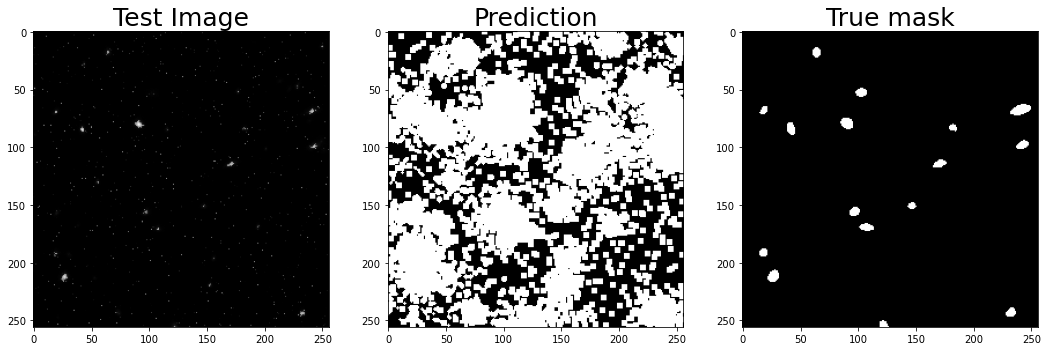

In [19]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
img  = image_dataset3[10]
pred = predictions3[10]
true = mask_dataset3[10]
pred[pred > 0] = 1
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(pred, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(true, cmap = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('cleaning_pred3.pdf')
plt.show();

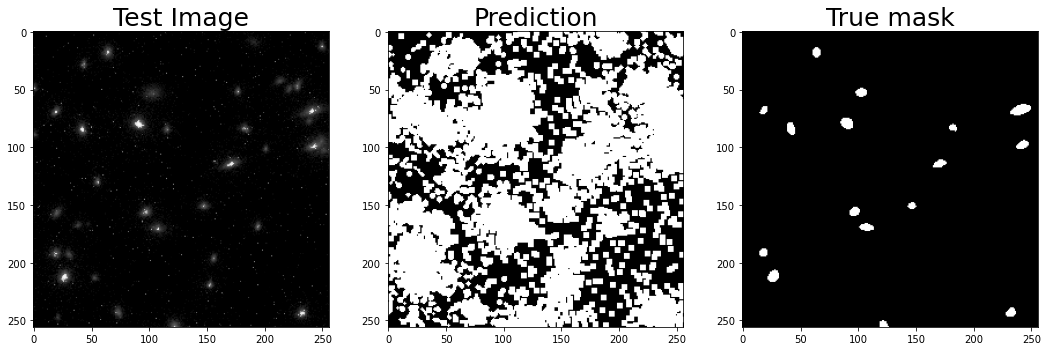

In [20]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
img  = image_dataset4[10]
pred = predictions4[10]
true = mask_dataset4[10]
#pred[pred > 0] = 1
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(pred, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(true, cmap = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('cleaning_pred4.pdf')
plt.show();

# extra

In [24]:
df1 = pd.read_csv('metrics_cleaning_1half.csv', index_col = 0)
df1

,IoU,recall,dice_coeff,Accuracy
Image w/Normalize,0.2509,0.9942,0.3971,0.9612
Image software w/Normalize,0.1125,0.1235,0.1980,0.7463


In [25]:
df = pd.concat([df1,metrics_df])
df

,IoU,recall,dice_coeff,Accuracy
Image w/Normalize,0.2509,0.9942,0.3971,0.9612
Image software w/Normalize,0.1125,0.1235,0.1980,0.7463
Image software + rms w/Normalize,0.0795,0.0918,0.1415,0.4669
Image software+ rms w/Normalize and streatch,0.1063,0.1181,0.1783,0.5320


In [26]:
df.to_csv('metrics_cleaning.csv')